In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
prec_temp = pd.read_csv('dataset\prec&temp(2000-01_2025-04).csv')

prec_temp.head(3)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN
0,IN001160200,"NELLORE, IN",14.45000,79.98300,20.00000,2000-01-01,0.00000,77,84.00000,70.00000
1,IN001160200,"NELLORE, IN",14.45000,79.98300,20.00000,2000-01-02,0.00000,76,84.00000,68.00000
2,IN001160200,"NELLORE, IN",14.45000,79.98300,20.00000,2000-01-03,0.00000,76,83.00000,69.00000


In [4]:
prec_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100743 entries, 0 to 100742
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   STATION    100743 non-null  object 
 1   NAME       100743 non-null  object 
 2   LATITUDE   100743 non-null  float64
 3   LONGITUDE  100743 non-null  float64
 4   ELEVATION  100743 non-null  float64
 5   DATE       100743 non-null  object 
 6   PRCP       35738 non-null   float64
 7   TAVG       100743 non-null  int64  
 8   TMAX       76757 non-null   float64
 9   TMIN       80551 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 7.7+ MB


In [5]:
city = prec_temp['NAME'].unique()
city

array(['NELLORE, IN', 'RATNAGIRI, IN', 'POONA, IN', 'MACHILIPATNAM, IN',
       'PATIALA, IN', 'JAIPUR SANGANER, IN', 'AGARTALA, IN',
       'TIRUCHCHIRAPALLI, IN', 'INDORE, IN', 'GOA PANJIM, IN',
       'AMRITSAR, IN'], dtype=object)

In [6]:
coord = prec_temp.drop_duplicates(subset = ['LATITUDE','LONGITUDE'])

geometry = gpd.points_from_xy(coord.LONGITUDE,coord.LATITUDE)
geo_city_data = gpd.GeoDataFrame(coord[["LATITUDE", "LONGITUDE"]],geometry=geometry)

geo_city_data


,LATITUDE,LONGITUDE,geometry
0,14.45000,79.98300,POINT (79.983 14.45)
9220,16.98300,73.33300,POINT (73.333 16.983)
18429,18.53300,73.85000,POINT (73.85 18.533)
27646,16.20000,81.15000,POINT (81.15 16.2)
36864,30.33300,76.46700,POINT (76.467 30.333)
46024,26.81700,75.80000,POINT (75.8 26.817)
54833,23.88300,91.25000,POINT (91.25 23.883)
63995,10.76700,78.71700,POINT (78.717 10.767)
73227,22.71700,75.80000,POINT (75.8 22.717)
82403,15.48300,73.81700,POINT (73.817 15.483)


In [7]:
prec_temp['City'] = prec_temp['NAME'].str.split(',', expand=True)[0]

# 3. For each city keep only one representative latitude/longitude
#    (assuming your CSV has LATITUDE and LONGITUDE columns)
city_coords = (
    prec_temp
    .dropna(subset=['LATITUDE','LONGITUDE'])        # make sure coords exist
    .drop_duplicates(subset='City')
    .loc[:, ['City','LATITUDE','LONGITUDE']]
    .reset_index(drop=True)
)

# 4. Create a Folium map centered on the dataset’s mean coordinates
mean_lat = city_coords['LATITUDE'].mean()
mean_lon = city_coords['LONGITUDE'].mean()
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=5)

m_small = folium.Map(
    location=[mean_lat, mean_lon],
    zoom_start=5,
    # width='50%',       # width in pixels (e.g. 600px)
    # height='50%'       # height in pixels (e.g. 400px)
)

# 5. Add one Marker per city
for _, row in city_coords.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        popup=row['City']
    ).add_to(m_small)

m_small

In [8]:
target_city = "AMRITSAR, IN"


city_data = prec_temp[prec_temp['NAME'] == target_city]

# city_data['DATE'] = pd.to_datetime(city_data['DATE'])

city_data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN,City
91564,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-01,NaN,47,66.00000,NaN,AMRITSAR
91565,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-02,NaN,58,NaN,NaN,AMRITSAR
91566,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-03,NaN,51,67.00000,NaN,AMRITSAR
91567,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-04,NaN,48,67.00000,NaN,AMRITSAR
91568,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-05,NaN,47,56.00000,NaN,AMRITSAR


In [9]:
city_data.shape

(9179, 11)

In [10]:
city_data.dropna()
city_data.shape

city_data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,TAVG,TMAX,TMIN,City
91564,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-01,NaN,47,66.00000,NaN,AMRITSAR
91565,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-02,NaN,58,NaN,NaN,AMRITSAR
91566,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-03,NaN,51,67.00000,NaN,AMRITSAR
91567,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-04,NaN,48,67.00000,NaN,AMRITSAR
91568,INM00042071,"AMRITSAR, IN",31.71000,74.79700,230.40000,2000-01-05,NaN,47,56.00000,NaN,AMRITSAR


In [11]:
city_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9179 entries, 91564 to 100742
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STATION    9179 non-null   object 
 1   NAME       9179 non-null   object 
 2   LATITUDE   9179 non-null   float64
 3   LONGITUDE  9179 non-null   float64
 4   ELEVATION  9179 non-null   float64
 5   DATE       9179 non-null   object 
 6   PRCP       2220 non-null   float64
 7   TAVG       9179 non-null   int64  
 8   TMAX       7604 non-null   float64
 9   TMIN       6775 non-null   float64
 10  City       9179 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 860.5+ KB


<Axes: xlabel='year', ylabel='TAVG'>

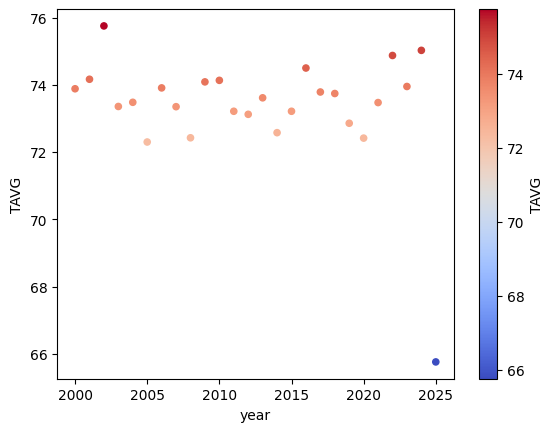

In [12]:
ndf = city_data

ndf['DATE'] = pd.to_datetime(ndf['DATE'])

ndf['year'] = ndf['DATE'].dt.year

dplt = pd.DataFrame()

years = city_data['year'].unique()
for i in years:
    city_data_avg = ndf[ndf['year'] == i]['TAVG'].mean()
    city_data_new = (ndf[ndf['year'] == i]).head(1)
    city_data_new['TAVG'] = city_data_avg
    dplt = pd.concat([dplt, city_data_new], ignore_index=True)

ann_city_data = dplt[['TAVG','year']]
ann_city_data.plot.scatter(x='year', y='TAVG', c = 'TAVG', cmap ='coolwarm')




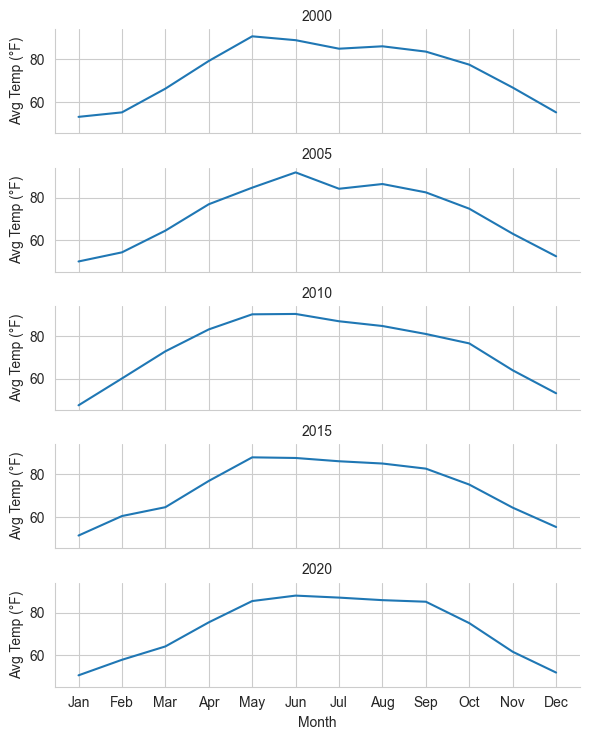

In [13]:

new_data = city_data
new_data['DATE'] = pd.to_datetime(new_data['DATE'])

new_data['year'] = new_data['DATE'].dt.year
new_data['month'] = new_data['DATE'].dt.month

monthly_avg = (
    new_data
    .dropna(subset=['TAVG'])
    .groupby(['year', 'month'])['TAVG']
    .mean()
    .reset_index()
)

years_to_show = [2000, 2005, 2010, 2015, 2020]
monthly_avg_filtered = monthly_avg[monthly_avg['year'].isin(years_to_show)]

sns.set_style("whitegrid")
g = sns.FacetGrid(
    monthly_avg_filtered,
    row='year',
    sharex=True,
    sharey=True,
    height=1.5,    # height of each facet in inches
    aspect=4       # width = aspect * height
)
g.map(sns.lineplot, 'month', 'TAVG')
g.set_axis_labels("Month", "Avg Temp (°F)")
g.set_titles("{row_name}")
g.set(
    xticks=range(1, 13),
    xticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)
plt.tight_layout()
plt.show()

In [18]:
df = city_data

In [19]:
df['PRCP'].describe()

count   2220.00000
mean       0.23302
std        0.58127
min        0.00000
25%        0.00000
50%        0.00000
75%        0.20000
max        8.07000
Name: PRCP, dtype: float64

In [21]:
missing_prcp = df['PRCP'].isna().sum()
missing_prcp

np.int64(6959)

In [22]:
zero_days = (df['PRCP'] == 0).sum()
zero_days

np.int64(1151)

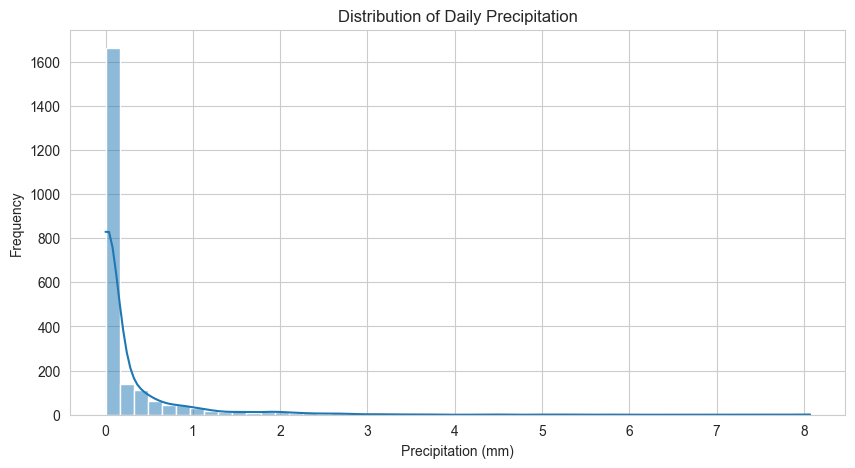

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df['PRCP'].dropna(), bins=50, kde=True)
plt.title("Distribution of Daily Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

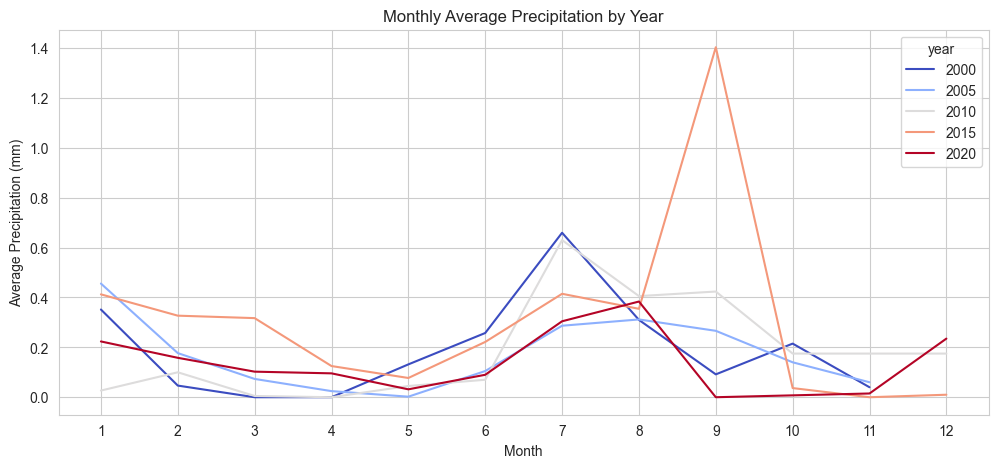

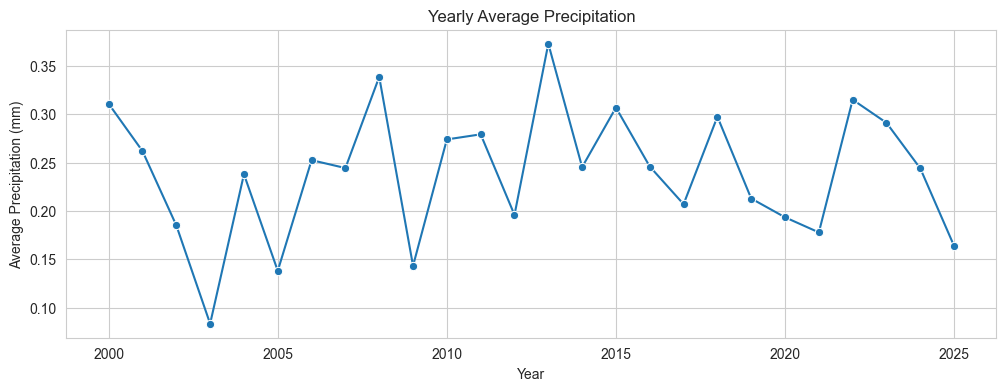

In [26]:
df['DATE'] = pd.to_datetime(df['DATE']) 
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

years_to_show = [2000, 2005, 2010, 2015, 2020]

# Filter the data for those years
filtered_df = df[df['year'].isin(years_to_show)]


monthly_avg = (
    filtered_df
    .groupby(['year', 'month'])['PRCP']
    .mean()
    .reset_index()
)

yearly_avg = df.groupby('year')['PRCP'].mean().reset_index()


plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_avg, x='month', y='PRCP', hue='year', palette='coolwarm')
plt.title("Monthly Average Precipitation by Year")
plt.xlabel("Month")
plt.ylabel("Average Precipitation (mm)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
sns.lineplot(data=yearly_avg, x='year', y='PRCP', marker='o')
plt.title("Yearly Average Precipitation")
plt.xlabel("Year")
plt.ylabel("Average Precipitation (mm)")
plt.grid(True)
plt.show()

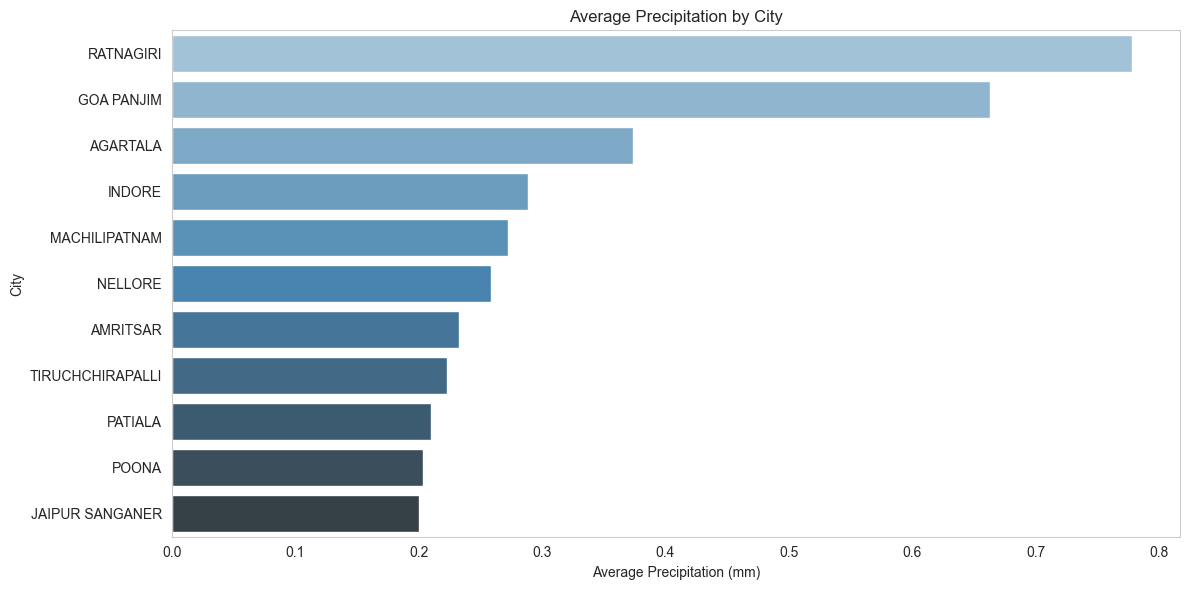

In [27]:
df = prec_temp

df['DATE'] = pd.to_datetime(df['DATE'])
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

# Drop missing precipitation or city values
geo_df = df.dropna(subset=['PRCP', 'City'])

# 1. Calculate average precipitation by city
city_avg_precip = (
    geo_df
    .groupby('City')['PRCP']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# 2. Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=city_avg_precip, x='PRCP', y='City', palette='Blues_d')
plt.title('Average Precipitation by City')
plt.xlabel('Average Precipitation (mm)')
plt.ylabel('City')
plt.grid(axis='x')
plt.tight_layout()
plt.show()